In [1]:
from forward import solve_forward
from simulation import Simulation
import numpy as np
import mat73
from net import EEG_CNN
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import cm

2022-02-14 21:35:29.309554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 21:35:29.309574: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
sources = np.load('../downsampled_dipoles-10k/1e-15/sources_10TeD.npy')
eeg = np.load('../downsampled_dipoles-10k/1e-15/eeg_10TeD.npy')
fwd = solve_forward(num_dipoles='10k')
eeg_topos = mat73.loadmat('../downsampled_dipoles-10k/1e-15/eeg_10TeD_topos.mat')['eeg_topos']
eeg_topos = eeg_topos.transpose(2, 0, 1)

sim = Simulation(fwd=fwd, source_data=sources, eeg_data=eeg)
eeg_cnn = EEG_CNN(sim=sim, eeg_topographies=eeg_topos)

eeg_cnn.load_nn('../Best Neural Nets/eeg_cnn_10k_dipoles.h5')

In [7]:
from net import EEGLargeCnn

eeg_cnn = EEGLargeCnn(None,None)
eeg_cnn.load_nn('../Best Neural Nets/model_5.h5')

Loaded model in EEGLargeCnn :
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 65, 8)         80        
                                                                 
 flatten (Flatten)           (None, 33800)             0         
                                                                 
 dense (Dense)               (None, 1024)              34612224  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                          

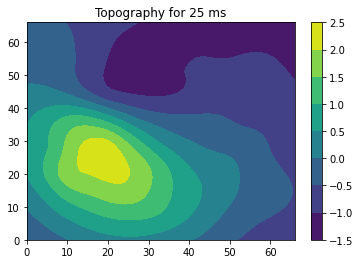

In [2]:
ms='25'
real_data_file = './real_data/{}ms/eeg_topo_real_{}ms.mat'.format(ms,ms)
topos_eval =  scipy.io.loadmat(real_data_file)['Zi'] 

plt.contourf(topos_eval, cmap=cm.get_cmap('viridis'))
cbar = plt.colorbar()
plt.title('Topography for {} ms'.format(ms.replace('_','.')))
plt.show()

topos_eval= np.expand_dims(topos_eval, axis=0)

In [13]:
topos = mat73.loadmat('../../Downloads/sim_data/eeg_topos.mat')

In [14]:
predicted_sources = eeg_cnn.predict(eeg_topos=topos_eval).T

In [11]:
np.save('../../Downloads/pred_sources.npy',predicted_sources)